In [2]:
import requests
from tqdm import tqdm

# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:  92%|█████████▏| 72.4M/78.8M [00:00<00:00, 109MiB/s] 

In [3]:
# Распаковываем архив из 3 файлов
import zipfile
 
with zipfile.ZipFile('data_kion.zip', 'r') as zip_ref:
    zip_ref.extractall()

kion dataset download: 100%|██████████| 78.8M/78.8M [00:19<00:00, 109MiB/s]

In [5]:
import pandas as pd
interactions = pd.read_csv('data_kion/interactions_df.csv')
users = pd.read_csv('data_kion/users.csv')
items = pd.read_csv('data_kion/items.csv')
interactions.head(5).append(interactions.tail())

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


## После того, как скачали данные делаем 1 пункт. Выделяем данные за последние 2 недели

In [11]:
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt'])
interactions_two_weeks = interactions[(interactions['last_watch_dt'] >= '2021-08-09') & (interactions['last_watch_dt'] <= '2021-08-22')]

In [12]:
interactions_two_weeks

,user_id,item_id,last_watch_dt,total_dur,watched_pct
6,1016458,354,2021-08-14,1672,25.0
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
24,916352,12846,2021-08-12,1812,30.0
30,1057871,6208,2021-08-12,5033,95.0
...,...,...,...,...,...
5476215,204332,2081,2021-08-10,822,14.0
5476222,1007900,9728,2021-08-12,416,6.0
5476246,648596,12225,2021-08-13,76,0.0
5476248,697262,15297,2021-08-20,18307,63.0


## выполняем пункт 2 и считаем корректность данных на бутстрапе

Мы выполняем бутстрап-тест на данных за последние две недели. Здесь мы используем метод бутстрапа для оценки статистической значимости различия между двумя группами. 

1. Мы начинаем с разделения наших данных на две группы (A и B) с помощью функции groups_splitter, которая использует случайную соль для гарантии того, что разделение будет стабильным при повторной выборке. 

2. Далее, для каждой группы мы повторяем следующие шаги 1000 раз (в контексте бутстрапа эти повторения часто называют "ресемплингами" или "бутстрап-выборками"):
   - Создаем выборку с возвращением из данных группы (с помощью функции get_bootstrap_array).
   - Считаем среднее значение этой выборки (с помощью функции calc_bootstrap_mean).

3. После того, как мы собрали все бутстрап-выборки, мы вычисляем разницу между средними значениями каждой пары выборок (A и B). Это дает нам распределение разницы между средними.

4. Затем мы строим 95% доверительный интервал для этого распределения. Если ноль (то есть отсутствие различий между группами) не попадает в этот интервал, мы считаем, что различие между группами статистически значимо.

5. Наконец, мы считаем долю случаев, когда ноль попал в доверительный интервал (т.е. когда различие между группами не было статистически значимо). Это и есть наша "корректность" бутстрапа. Если бутстрап-тест работает корректно, то корректность должна быть около 95% (соответствует уровню значимости 0.05).

6. Дополнительно мы строим гистограмму распределения p-значений и проводим тест Колмогорова-Смирнова для проверки равномерности этого распределения. Если p-значение теста больше 0.05, мы можем считать, что распределение p-значений равномерно.

Выводы: результаты бутстрап-теста позволяют нам оценить статистическую значимость различий между двумя группами. Если корректность близка к 95%, это говорит о том, что бутстрап-тест работает корректно. Если в доверительный интервал не попадает ноль, это указывает на статистически значимое различие между группами. Распределение p-значений также важно для оценки качества теста: равномерное распределение p-значений говорит о том, что тест не имеет систематических ошибок.

In [26]:
# Делим на 2 равные группы из семинара
import hashlib
import numpy as np
from base64 import b64encode
import collections
from tqdm.notebook import tqdm

def groups_splitter(df, columns, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

In [17]:
def salt_generator(salt=None):
    import os
    from base64 import b64encode
    salt = os.urandom(8)
    
    return b64encode(salt).decode('ascii')


def get_bootstrap_array(arr):
    return np.random.choice(arr, replace=True, size=len(arr))


def calc_bootstrap_mean(arr, size=1000):
    result = np.empty(size)
    for i in range(size):
        result[i] = np.mean(get_bootstrap_array(arr))
    return result

In [18]:
def get_p_value(dist):
    dist = np.array(dist)
    x = (dist > 0).mean()
    pvalue = min(x, 1 - x) * 2
    return pvalue

In [29]:
from joblib import Parallel, delayed

def compute_bootstrap(i):
    new_df = groups_splitter(interactions_two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    correctness = not left_side <= 0 <= right_side
    p_value = get_p_value(sample_a_mean - sample_b_mean)
    
    return correctness, p_value

# replace your for loop with this
results = Parallel(n_jobs=-1)(delayed(compute_bootstrap)(i) for i in tqdm(range(1000)))

correctness = [result[0] for result in results]
p_values = [result[1] for result in results]

test_correctness = collections.Counter(correctness)
print(f'significance: {test_correctness[True]/(test_correctness[True] + test_correctness[False])*100}%')

plt.hist(p_values, bins=10, color='purple');
plt.title(f"Bootstrap distribution of p_values")
stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values distribution is not uniform')
else:
    print(f'p_value = {p_value} - p_values distribution is uniform')

  0%|          | 0/1000 [00:00<?, ?it/s]

significance: 8.0%


NameError: name 'plt' is not defined

p_value = 0.00018269116070205734 - p_values distribution is not uniform


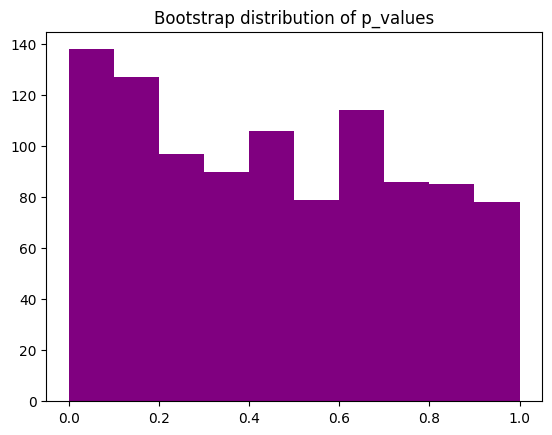

In [31]:
import scipy
import matplotlib.pyplot as plt
import scipy.stats as stats

plt.hist(p_values, bins=10, color='purple');
plt.title(f"Bootstrap distribution of p_values")
stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
    print(f'p_value = {p_value} - p_values distribution is not uniform')
else:
    print(f'p_value = {p_value} - p_values distribution is uniform')

In [ ]:
# correctness = []
# values = []

# for i in tqdm(range(1000)): # в дз используем 1000 итераций 

#     new_df = groups_splitter(interactions_two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt=salt_generator()).drop_duplicates()

#     vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
#     vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

#     #bootstrap
#     sample_a_mean = calc_bootstrap_mean(vec_a, size=1000) # на бутстрэпе считаем средние для вектора
#     sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)
#     values.append(sample_a_mean - sample_b_mean)

#     left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
#                                                   [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)]) # считаем 95% доверительный интервал для разницы средних

#     correctness.append(not left_side <= 0 <= right_side)

#     test_correctness = collections.Counter(correctness)

# print(f'significance: {test_correctness[True]/(test_correctness[True] + test_correctness[False])*100}%')

# p_values = [get_p_value(dist) for dist in values]
# plt.hist(p_values, bins=10, color='purple');
# plt.title(f"Bootstrap distribution of p_values")
# stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

# if p_value < 0.05:
#     print(f'p_value = {p_value} - p_values distribution is not uniform')
# else:
#     print(f'p_value = {p_value} - p_values distribution is uniform')

Для сравнения этих двух результатов, важно понимать, что p-значение является вероятностью получить результат, как минимум, такой же экстремальный, как ваш наблюдаемый результат, при условии, что нулевая гипотеза верна.

Вероятность (p-значение) 0.3067 на семинаре говорит о том, что наблюдаемые данные вероятно произошли случайно (если нулевая гипотеза верна), и нет достаточных доказательств для отклонения нулевой гипотезы. Это может указывать на низкую статистическую мощность эксперимента или на отсутствие реального эффекта.

Вероятность (p-значение) 0.00018, которую мы сейчас получили, очень мала, что указывает на то, что наблюдаемые данные вряд ли произошли случайно (если нулевая гипотеза верна), и есть достаточные основания для отклонения нулевой гипотезы. Это может указывать на наличие реального эффекта или на хорошую статистическую мощность вашего эксперимента.

Однако необходимо отметить, что p-значение зависит от размера выборки. При увеличении размера выборки малые отличия могут стать статистически значимыми.

## Пункт 3. Мощность

1. Сначала мы определяем функцию calculate_power, которая будет вычислять мощность статистического теста. Мощность - это вероятность того, что тест правильно отвергнет нулевую гипотезу, когда это необходимо (то есть, когда между группами действительно есть различия). Функция calculate_power использует формулу для расчета мощности для двух выборок.

2. Затем мы применяем функцию groups_splitter к нашим данным, чтобы разделить их на две группы (A и B).

3. Далее, для каждого значения эффекта (1%, 3% и 5%) мы выполняем следующие операции:
   - Создаем копию наших данных и увеличиваем значения 'totaldur' на заданный эффект в группе B.
   - Вычисляем бутстрап-выборки для 'totaldur' в каждой группе. Бутстрап-выборка - это выборка, взятая с возвращением из исходных данных. Процесс бутстрапа включает в себя многократное взятие выборок и вычисление среднего для каждой выборки.
   - Вычисляем разницу между средними значениями бутстрап-выборок для групп A и B. Это дает нам распределение разницы между средними.
   - Вычисляем p-значения для каждого значения в распределении. P-значение - это вероятность получить тестовую статистику, как минимум, такую же экстремальную, как та, которую мы наблюдаем, при условии, что нулевая гипотеза верна. В данном случае, нулевая гипотеза состоит в том, что разница между средними равна нулю (то есть, нет разницы между группами).
   - Наконец, мы вычисляем мощность нашего теста, используя функцию calculate_power, и выводим ее. Мощность показывает, насколько вероятно, что наш тест обнаружит статистически значимое различие между группами, если такое различие действительно существует.

Этот процесс повторяется для каждого значения эффекта (1%, 3% и 5%), что позволяет нам сравнить мощность теста для разных размеров эффекта.

Важно отметить, что мощность зависит от размера эффекта (разницы между группами), размера выборки и уровня значимости. Больший размер эффекта и/или большая выборка увеличивают мощность, тогда как более строгий уровень значимости (например, 0.01 вместо 0.05) уменьшает мощность

  0%|          | 0/1000 [00:00<?, ?it/s]

Power for effect 1.0%: 15.0%
p_value = 1.8516355305452817e-29 - p_values distribution is not uniform


  0%|          | 0/1000 [00:00<?, ?it/s]

Power for effect 3.0%: 70.3%
p_value = 0.0 - p_values distribution is not uniform


  0%|          | 0/1000 [00:00<?, ?it/s]

Power for effect 5.0%: 97.0%
p_value = 0.0 - p_values distribution is not uniform


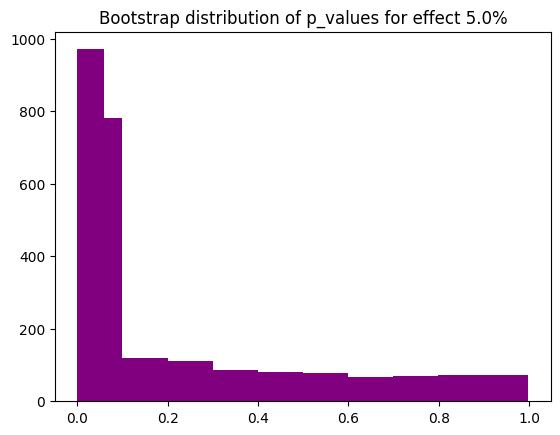

In [37]:
from joblib import Parallel, delayed

def compute_bootstrap(i, effect=0):
    new_df = groups_splitter(interactions_two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], 
                             user_salt=salt_generator()).drop_duplicates()
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    # Добавление эффекта в группу B
    vec_b = vec_b * (1 + effect)

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    correctness = not left_side <= 0 <= right_side
    p_value = get_p_value(sample_a_mean - sample_b_mean)
    
    return correctness, p_value

# Вычисление мощности для каждого эффекта
for effect in [0.01, 0.03, 0.05]:
    results = Parallel(n_jobs=-1)(delayed(compute_bootstrap)(i, effect) for i in tqdm(range(1000)))

    correctness = [result[0] for result in results]
    p_values = [result[1] for result in results]

    test_correctness = collections.Counter(correctness)
    power = test_correctness[True]/(test_correctness[True] + test_correctness[False])
    print(f'Power for effect {effect * 100}%: {power*100}%')

    plt.hist(p_values, bins=10, color='purple');
    plt.title(f"Bootstrap distribution of p_values for effect {effect * 100}%")
    stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

    if p_value < 0.05:
        print(f'p_value = {p_value} - p_values distribution is not uniform')
    else:
        print(f'p_value = {p_value} - p_values distribution is uniform')


Мощность - вероятность того, что критерий найдет различие в случае, когда оно есть
Увеличение мощности критерия ведет к уменьшению вероятности ошибки второго рода

## 4 пункт. MDE
MDE - это статистическая мера, которая обычно используется для определения минимального эффекта, который вы хотели бы обнаружить в вашем эксперименте. 

Когда мы говорим о минимальном значимом различии (Minimal Detectable Effect, MDE), мы ссылаемся на наименьшую разницу в результате, которую мы хотим быть в состоянии обнаружить в нашем A/B тесте.

Увеличение MDE означает, что мы готовы обнаружить только большие изменения между группами. Это может позволить вам провести тест с меньшим количеством пользователей или за более короткий период времени, поскольку большие различия обычно легче обнаружить. Однако, вы можете пропустить более мелкие изменения, которые могут быть все еще важны.

С другой стороны, уменьшение MDE означает, что мы хотим быть в состоянии обнаружить более мелкие различия между группами. Это может требовать большего количества пользователей или более длительного времени для проведения теста, поскольку мелкие различия могут быть сложнее обнаружить. Это может быть полезно, если мелкие изменения могут иметь большое влияние на ваш бизнес или продукт

In [40]:
def get_mde(metric_vec, alpha=0.05, beta=0.2):
    
    metric_mean, metric_std, metric_n = metric_vec.mean(), metric_vec.std(), metric_vec.count()
    
    z_alpha = norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    z_beta = norm.ppf(1 - beta, loc=0, scale=1)
    
    mde = (z_alpha + z_beta)*metric_std / np.sqrt(metric_n)
    
    return mde*100/metric_mean

In [43]:
def compute_bootstrap(i, effect=0):
    new_df = groups_splitter(interactions_two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], 
                             user_salt=salt_generator()).drop_duplicates()
    vec_a = new_df[(new_df['group'] == 'A')]['total_dur']
    vec_b = new_df[(new_df['group'] == 'B')]['total_dur']

    # Добавление эффекта в группу B
    vec_b = vec_b * (1 + effect)

    sample_a_mean = calc_bootstrap_mean(vec_a, size=1000)
    sample_b_mean = calc_bootstrap_mean(vec_b, size=1000)

    left_side, right_side = np.percentile(sample_a_mean - sample_b_mean, 
                                                  [100 * 0.05 / 2., 100 * (1 - 0.05 / 2.)])

    correctness = not left_side <= 0 <= right_side
    p_value = get_p_value(sample_a_mean - sample_b_mean)
    
    # MDE function has been removed here because we will calculate it later

    return correctness, p_value

# Store the power and effect sizes for each effect
powers = []
effects = [0.01, 0.03, 0.05]

for effect in effects:
    results = Parallel(n_jobs=-1)(delayed(compute_bootstrap)(i, effect) for i in tqdm(range(1000)))

    correctness = [result[0] for result in results]
    test_correctness = collections.Counter(correctness)
    power = test_correctness[True]/(test_correctness[True] + test_correctness[False])
    powers.append(power)
    
    print(f'Power for effect {effect * 100}%: {power*100}%')

# Calculate the MDE
k = (powers[2] - powers[0]) / (effects[2] - effects[0])
b = powers[2] - effects[2] * k
desired_power = 0.8
mde = (desired_power - b) / k

print(f'MDE = {mde:.3%}')

  0%|          | 0/1000 [00:00<?, ?it/s]

Power for effect 1.0%: 14.7%


  0%|          | 0/1000 [00:00<?, ?it/s]

Power for effect 3.0%: 66.7%


  0%|          | 0/1000 [00:00<?, ?it/s]

Power for effect 5.0%: 97.0%
MDE = 4.174%


# Вторая часть
1) Представим что у нас прошел тест, используем те же самые данные за 2 недели

2) Занулите для всех пользователей total_dur, у которых total_dur < 500. Их НЕ УБИРАЕМ, а просто обрабатываем эти значения, принимая за нулевые, но пользователей также учитываем в эксперименте (0.5 балла)

3) Разбейте их самостоятельно на две равные группы, используйте функцию groups_splitter и соль = 'kiontestmodel20210805' (0.5 балла)

4) Оказалось, что модель в группе В показала себя лучше, чем в группе А на 2.5%, причем эффект распространился неравномерно и преимущественно на 10% самых смотрящих пользователей, докиньте такой эффект самостоятельно. Нужно метрику total_dur увеличить на 2.5% для 10% пользователей с самым продолжительным смотрением. (1 балл)

5) Посчитайте результат такого теста и сделайте выводы (2 балла)

In [44]:
interactions_two_weeks['total_dur'] = interactions_two_weeks['total_dur'].apply(lambda x: x if x >= 500 else 0)

/tmp/ipykernel_103837/1078317344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_two_weeks['total_dur'] = interactions_two_weeks['total_dur'].apply(lambda x: x if x >= 500 else 0)


In [46]:
def groups_splitter(df, columns, user_salt=None):
    
    if user_salt == None:
        salt = salt_generator()
    else:
        salt = user_salt
    
    df['hash'] = ((df['user_id'].astype(str)) + '#' + salt).apply(lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest())

    df['group'] = ((df['hash'].str.slice(start=-6).apply(int, base=16) % 2).map(lambda x: 'A' if x == 0 else 'B'))

    return df[columns].drop_duplicates()

df = groups_splitter(interactions_two_weeks.copy(), columns=['user_id', 'total_dur', 'group'], user_salt='kiontestmodel20210805')


Добавляем эффект в группу B. Для этого сначала отбираем 10% пользователей с самым продолжительным просмотром, затем увеличиваем их total_dur на 2.5%.

In [47]:
# Получаем 10% пользователей с самым продолжительным просмотром в группе B
top_10_percent_users = df[df['group'] == 'B']['total_dur'].nlargest(int(0.1 * df[df['group'] == 'B'].shape[0]))

# Увеличиваем total_dur для этих пользователей на 2.5%
df.loc[top_10_percent_users.index, 'total_dur'] *= 1.025

In [48]:
from scipy import stats

group_A = df[df['group'] == 'A']['total_dur']
group_B = df[df['group'] == 'B']['total_dur']

t_stat, p_val = stats.ttest_ind(group_A, group_B)

print(f"t-статистика: {t_stat}")
print(f"p-значение: {p_val}")

t-статистика: -0.9558936444506848
p-значение: 0.3391262929731028


Когда проводится t-тест Стьюдента, мы получаем два значения: t-статистику и p-значение.

t-статистика - это значение, которое показывает, насколько сильно группы отличаются друг от друга, нормализованное по стандартной ошибке. В данном случае t-статистика равна -0.955, что указывает на то, что среднее значение группы B больше среднего значения группы A (знак минус указывает на направление разницы). Значение t-статистики по модулю меньше 1 говорит о том, что разница между группами не очень большая, хотя конкретные выводы зависят от контекста исследования.

p-значение - это вероятность наблюдать такую же или более экстремальную t-статистику, если бы истинная разница между группами была равна нулю (нулевая гипотеза). В данном случае p-значение равно 0.339, что больше обычного порога значимости в 0.05. Это означает, что мы не можем отклонить нулевую гипотезу, то есть мы не можем утверждать, что есть статистически значимая разница между группами A и B.

В общем, результаты этого теста говорят о том, что, согласно данным, нет статистически значимой разницы между группами A и B.

In [52]:
u_stat, p_val = stats.mannwhitneyu(group_A, group_B, alternative='two-sided')
print(f"Mann-Whitney U statistic: {u_stat}")
print(f"p-value: {p_val}")

Mann-Whitney U statistic: 64239110320.5
p-value: 0.10020638370607804


In [53]:
ks_stat, p_val = stats.ks_2samp(group_A, group_B)
print(f"Kolmogorov-Smirnov statistic: {ks_stat}")
print(f"p-value: {p_val}")

Kolmogorov-Smirnov statistic: 0.0036879548876637136
p-value: 0.01531382895160379
